[![deep-learning-notes](https://github.com/semilleroCV/deep-learning-notes/raw/main/assets/banner-notebook.png)](https://github.com/semilleroCV/deep-learning-notes)

In [ ]:
%%capture
#@title **install required packages**
! pip install torchinfo

In [3]:
#@title **import required libraries**
import torch # 2.2.1
import torch.nn as nn # 2.2.1
from torchinfo import summary

In order not to saturate with a lot of text, each of the modules are explained just before the class implementation. But the general idea of the model pipeline is the following:

1. Convert input sentences to embeddings.
2. Add positional encoding to embeddings.
3. Process through the encoder with multi-head self-attention and feed-forward layers, with residual connections and layer normalization.
4. Decoder processes the encoded output and the target sentence with added masked self-attention.
5. Apply linear projection.

Comments: Softmax is omitted for flexibility, embeddings are scaled by √dmodel, and dropout (rate 0.1) is applied to sub-layer outputs, embeddings, and positional encodings.

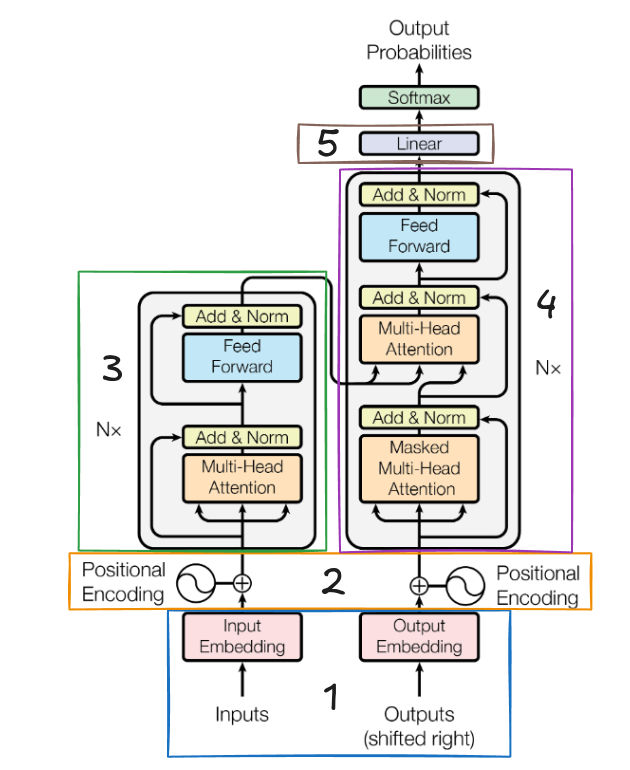

1. Here, each sentence has already been converted into embeddings, this is done in the `Transformer` class with the `nn.Embedding` module.
2. Then, a encoded position (`PositionalEncoding`) is added to each of the sentence embeddings, this is done because the model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. 

We can visualize what is happening with the following example:

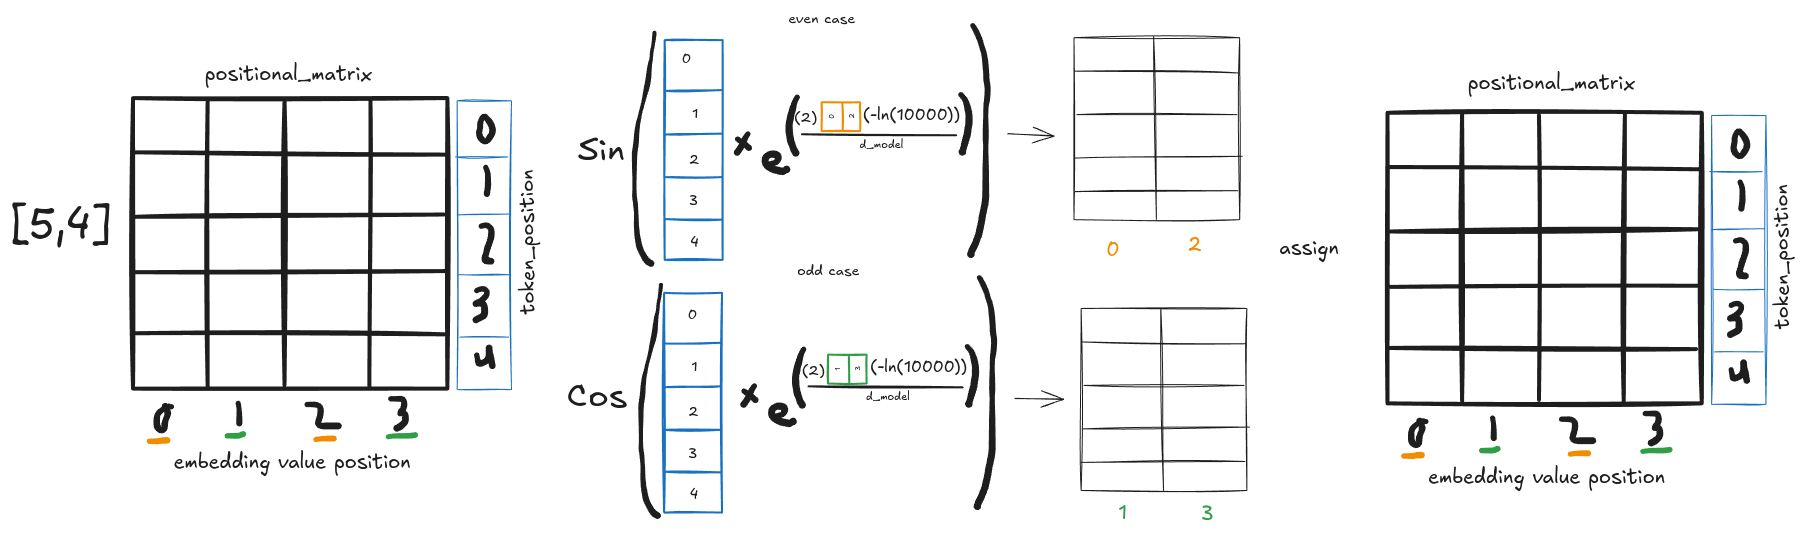

In [4]:
class PositionalEncoding(nn.Module):
  """
  Some Information about PositionalEncoding

  d_model: The size of the word embeddings to be used.
  max_seq_len: The maximum number of tokens the model can
  receive, here is useful to know how many functions to generate.
  """
  def __init__(self, max_seq_len:int=128, d_model:int=512, device:str='cpu'):
    super(PositionalEncoding, self).__init__()
    self.positional_matrix = torch.zeros(max_seq_len, d_model, device=device)
    
    token_position = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
    
    div_term = torch.exp(2*torch.arange(0, d_model, 1, dtype = torch.float) * -torch.log(torch.tensor(10000)) / d_model)
    # div_term = torch.exp(torch.arange(0, d_model, 2, dtype = torch.float) * -torch.log(torch.tensor(10000)) / d_model)
    
    self.positional_matrix[:, 0::2] = torch.sin(token_position*div_term[0::2])
    self.positional_matrix[:, 1::2] = torch.cos(token_position*div_term[1::2])
    # self.positional_matrix[:, 1::2] = torch.cos(token_position*div_term)
    # self.positional_matrix[:, 1::2] = torch.cos(token_position*div_term)
    self.positional_matrix = self.positional_matrix.unsqueeze(0).transpose(0, 1)
    # print(self.positional_matrix, self.positional_matrix.size())

  def forward(self, x):
    return x + self.positional_matrix[:x.size(0), :] # we only add up to the number of tokens that come in the sequence, not the rest because it will be padding.

In [5]:
# Test the module to see if it gives the expected result.

pos = PositionalEncoding(5, 4)
source = torch.randn(2, 3, 4)
print(source, source.size())
source = pos(source)
print(source, source.size())

tensor([[[-0.6334,  0.5488, -1.7490,  2.4795],
         [-0.2349, -0.2901, -1.1881, -0.0349],
         [-1.5008,  0.2563, -1.1518,  0.1831]],

        [[-0.7615, -0.1309,  0.6104,  2.0377],
         [-0.7606,  0.2870, -1.6489,  1.9997],
         [ 0.9091,  0.6577, -0.0079,  0.5315]]]) torch.Size([2, 3, 4])
tensor([[[-0.6334,  1.5488, -1.7490,  3.4795],
         [-0.2349,  0.7099, -1.1881,  0.9651],
         [-1.5008,  1.2563, -1.1518,  1.1831]],

        [[ 0.0799,  0.8691,  0.6105,  3.0377],
         [ 0.0809,  1.2870, -1.6488,  2.9997],
         [ 1.7505,  1.6577, -0.0078,  1.5315]]]) torch.Size([2, 3, 4])


In [6]:
class MultiHeadAttention(nn.Module):
  """
  for a detailed explanation of MultiHeadAttention
  refer to https://github.com/semilleroCV/deep-learning-notes/blob/main/notebooks/modules/multi-head-attention.ipynb
  """

  def __init__(self, d_model:int = 512, num_heads:int = 8):
    super(MultiHeadAttention, self).__init__()
    
    # We make sure that the division is integer.
    assert d_model % num_heads == 0, "Size not compatible with number of heads"

    self.num_heads = num_heads
    self.d_v = d_model//num_heads
    self.d_k = self.d_v

    # In order not to have to make h matrices we will "extend" them from d_k to d_model
    # that is, d_k, h times.
    self.W_q = nn.Linear(d_model, self.d_k * num_heads)
    self.W_k = nn.Linear(d_model, self.d_k * num_heads)
    self.W_v = nn.Linear(d_model, self.d_k * num_heads)
    self.W_o = nn.Linear(self.d_v * num_heads, d_model)

  def forward(self, Q, K, V, mask = None):

    batch_size = Q.size(0)

    Q, K, V = self.W_q(Q), self.W_k(K), self.W_v(V)
    Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # here we are "deconcatenating" the Querys for each head.
    K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    V = V.view(batch_size, -1, self.num_heads, self.d_v).transpose(1, 2)

    """ 
      Q, K and V -> [batch_size, seq_len, d_k * num_heads]
      after transpose Q, K and V -> [batch_size, num_heads, seq_len, d_k]
    """

    weighted_values = self.scaled_dot_pruduct_attention(Q, K, V, mask)

    # contiguous() will rearrange the memory allocation so that the tensor is C contiguous https://stackoverflow.com/questions/48915810/what-does-contiguous-do-in-pytorch
    weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k) # we have to concatenate the output of the scaled_dot_product

    """
    weighted_values -> [batch_size, num_heads, seq_len, d_k]
    after transpose weighted_values -> [batch_size, seq_len, num_heads * d_k]
    """

    weighted_values = self.W_o(weighted_values) # [batch_size, seq_len, d_model]

    return weighted_values
  
  def scaled_dot_pruduct_attention(self, Q, K, V, mask = None):
      
      # matmul operates for each head
      compatibility = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k)) # the transpose here is, as in the paper, so that the multiplication between matrices can be done

      if mask is not None:
         compatibility = compatibility.masked_fill(mask == 0, -float('inf')) # pay attention only to the tokens we are interested in

      attention = nn.Softmax(dim=-1)(compatibility) # dim=-1 is to be applied for each vector of q, k and v, [batch_size, num_heads, seq_len, seq_len]
      weighted_values = torch.matmul(attention, V)
      return weighted_values

In [7]:
# Test the module to see if it gives the expected result.

d_model, seq_len, num_heads, d_k = 4, 2, 2, 2

module = MultiHeadAttention(d_model, num_heads)
sentence = torch.randn(1, seq_len, d_model)
module(sentence, sentence, sentence)

tensor([[[ 0.0250, -0.8148, -0.4131, -0.0258],
         [ 0.1219, -0.8242, -0.4674,  0.0290]]], grad_fn=<ViewBackward0>)

In [8]:
class PositionWiseFeedForward(nn.Module):
  """Some Information about PositionWiseFeedForward"""
  def __init__(self, d_ff:int=2048, d_model:int=512):
    super(PositionWiseFeedForward, self).__init__()
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.linear_2 = nn.Linear(d_ff, d_model) 

  def forward(self, x):
    x = nn.ReLU()(self.linear_1(x))
    return self.linear_2(x)

In [9]:
class EncoderLayer(nn.Module):
  """Some Information about EncoderLayer"""
  def __init__(self, d_model:int=512, d_ff:int=2048, 
               num_heads:int=8, dropout:int=0.1):
    super(EncoderLayer, self).__init__()

    self.dropout = dropout

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
    # dropout 1
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.feed_forward = PositionWiseFeedForward(d_ff, d_model)
    # dropout 2
    self.layer_norm_2 = nn.LayerNorm(d_model)

  def forward(self, x, mask = None):
    # Multi-Head Attention and Dropout
    attention_score, _ = self.multi_head_attention(x, x, x, mask)
    attention_score = nn.Dropout(self.dropout)(attention_score)

    # Add and Layer norm 1
    x = self.layer_norm_1(x + attention_score)

    # Feed Forward and Dropout 
    ff_output = nn.Dropout(self.dropout)(self.feed_forward(x))

    # Add and Layer norm 2
    x = self.layer_norm_2(x + ff_output)
    return x

3. At this point, the source sentence first passes through the **Enconder**, which is composed of a stack of N = 6 identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism (`MultiHeadAttention`), and the second is a simple, positionwise fully connected feed-forward network (`PositionWiseFeedForward`). We employ a residual connection [11] around each of the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel = 512.

In [10]:
class Encoder(nn.Module):
  """
  A Transformer encoder with multiple layers (`EncoderLayer`) that applies self-attention and feed-forward mechanisms. 
  Processes input sequences into encoded representations. Includes layer normalization for stability.

  Args:
  - d_model (int): Dimension of embeddings.
  - n_layers (int): Number of encoder layers.
  - d_ff (int): Feed-forward hidden layer size.
  - num_heads (int): Attention heads.
  - dropout (float): Dropout rate.
  """
  def __init__(self, d_model:int=512, n_layers:int=6, d_ff:int=2048, 
               num_heads:int=8, dropout:int=0.1):
    super(Encoder, self).__init__()
    self.layers = nn.ModuleList(EncoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(n_layers))
    self.layer_norm = nn.LayerNorm(d_model)


  def forward(self, x, mask = None):
    """
    The encoder is also masked so as not to attend to the padding tokens.
    """
    for layer in self.layers:
      x = layer(x, mask)
    return self.layer_norm(x)

In [11]:
class DecoderLayer(nn.Module):
  """Some Information about DecoderLayer"""
  def __init__(self, d_model:int=512, d_ff:int=2048, num_heads:int=8, dropout:int=0.1):
    super(DecoderLayer, self).__init__()
    self.dropout = dropout

    self.multi_head_attention_1 = MultiHeadAttention(d_model, num_heads)
    # dropout 1
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.cross_attention = MultiHeadAttention(d_model, num_heads)
    # dropout 2
    self.layer_norm_2 = nn.LayerNorm(d_model)
    self.feed_forward = PositionWiseFeedForward(d_ff, d_model)
    # dropout 3
    self.layer_norm_3 = nn.LayerNorm(d_model)

  def forward(self, x, encoder_output, encoder_mask = None, target_mask = None):

    # Multi-Head attention and Dropout
    attention_score, _ = self.multi_head_attention_1(x, x, x , target_mask)
    attention_score = nn.Dropout(self.dropout)(attention_score)

    # Add and layer norm 1
    x = self.layer_norm_1(x + attention_score)

    # Multi-Head attention and Dropout
    cross_attention_score, _ = self.cross_attention(x, encoder_output, encoder_output, encoder_mask)
    cross_attention_score = nn.Dropout(self.dropout)(cross_attention_score)

    # Add and layer norm 2
    x = self.layer_norm_2(x + cross_attention_score) 

    # Feed forward and Dropout
    ff_output = nn.Dropout(self.dropout)(self.feed_forward(x))

    # Add and layer norm 3
    x = self.layer_norm_3(x + ff_output)
           
    return x

4. After the encoder processes or encodes the source sentence, **Decoder** operation begins. The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

When it is said that the model does not attend to subsequent positions means that if we are translating, for example, from Spanish to English the sentence "Me gusta estudiar" and in the first iteration we get the token "I" which is related to "Me" then the Decoder must attend only to these two tokens and not to the rest of the translation "like to study" which has not yet been generated, basically we are preventing the model from cheating.

In [12]:
class Decoder(nn.Module):
  """
  A Transformer decoder with multiple layers (`DecoderLayer`) that applies self-attention and cross-attention mechanisms. 
  Takes encoded input and generates final sequence outputs. Includes layer normalization for stability.

  Args:
  - d_model (int): Dimension of embeddings.
  - n_layers (int): Number of decoder layers.
  - d_ff (int): Feed-forward hidden layer size.
  - num_heads (int): Attention heads.
  - dropout (float): Dropout rate.
  """
  def __init__(self, d_model:int=512, n_layers:int=6, d_ff:int=2048, 
               num_heads:int=8, dropout:int=0.1):
    super(Decoder, self).__init__()
    self.layers = nn.ModuleList(DecoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(n_layers))
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, x, encoder_output, encoder_mask = None, target_mask = None):
    """
    params:
    x: the input of the encoder, these are the translations so far
    ouput_encoder: will be the output of the enconder to do cross attention
    encoder_mask: the mask used in the encoder to not attend padding
    target_mask: the mask used by the decoder to not attend to subsequent words
    """
    for layer in self.layers:
      x = layer(x, encoder_output, encoder_mask, target_mask)

    return self.layer_norm(x)

5. At the end when the encoder and decoder have done their job, we do a linear projection. 

Three additional comments is that (i) the softmax layer is not implemented in the model because it can be implemented at the time of training, so the model is a little more general to be applied in different tasks, (ii) in the embedding layers, we multiply those weights by √dmodel y (iii) dropout [33] is applied at the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of P_drop = 0.1.

In [16]:
class Transformer(nn.Module):
  """
  Some Information about Transformer
  
  params:
  source_vocab_size: The size (tokens) of input sentences
  target_vocab_size: The size (tokens) of the output sentences
  d_model: The size of the word embeddings to use
  n_layers: The number of enconder-decoder layers to use
  d_ff: Number of neurons in the inner layer of feed forward sublayer
  num_heads: The number of heads in the self-attention module
  max_seq_len: The maximum number of tokens that the model can receive
  dropout: Dropout probability 
  """

  def __init__(self, source_vocab_size:int, target_vocab_size:int, device:str='cpu', d_model:int=512, n_layers:int=6, 
               d_ff:int=2048, num_heads:int=8, max_seq_len:int=128, dropout:int=0.1):
    super(Transformer, self).__init__()

    self.device = device
    self.d_model = d_model
    self.dropout = dropout

    self.encoder_embedding = nn.Embedding(source_vocab_size, d_model)
    self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
    self.positional_encoding = PositionalEncoding(max_seq_len, d_model, device) # dropout
    self.encoder = Encoder(d_model, n_layers, d_ff, num_heads, dropout)
    self.decoder = Decoder(d_model, n_layers, d_ff, num_heads, dropout)
    self.output_layer = nn.Linear(d_model, target_vocab_size) 

  def forward(self, source, target):
    """
    params:
    source: input language sentence
    target: output language sentence
    """

    # 1. Encoder and decoder masks
    source_mask, target_mask = self.mask(source, target)

    # 2. Encoder embedding and positional encoding
    source = self.encoder_embedding(source) * torch.sqrt(torch.tensor(self.d_model)) # Like in the paper, in the embedding layers, we multiply those weights by √dmodel.
    source = nn.Dropout(self.dropout)(self.positional_encoding(source))

    # 3. Encoder
    encoder_output = self.encoder(source, source_mask)

    # 1 and 2. Decoder embedding and positional encoding
    target = self.decoder_embedding(target) * torch.sqrt(torch.tensor(self.d_model))
    target = nn.Dropout(self.dropout)(self.positional_encoding(target))

    # 4. Decoder
    output = self.decoder(target, encoder_output, source_mask, target_mask)

    return self.output_layer(output) # 5. Linear projection

  def mask(self, source, target):
    """
    This function will allow us to pay attention only to the tokens we have seen.

    Modify the self-attention sub-layer in the decoder stack to prevent positions
    from attending to subsequent positions. This masking, combined with fact that the output 
    embeddings are offset by one position, ensures that the predictions for position i can 
    depend only on the known outputs at positions less than i. It is also used to prevent our
    model from not paying attention to padding tokens. 
    """

    source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
    target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
    size = target.size(1)
    no_mask = torch.tril(torch.ones((1, size, size), device = self.device)).bool()
    target_mask = target_mask & no_mask
    return source_mask, target_mask

In [17]:
# Test the model to see if it gives the expected result.

# We assume that the input and output sentence is 10 words long.
seq_len_source = 10 
seq_len_target = 10

batch_size = 2

# We assume that the number of words in the source and target vocabulary are 50.
source_vocab_size = 50
target_vocab_size = 50

source = torch.randint(1, source_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(source_vocab_size, target_vocab_size, device)

model.to(device)
source.to(device)
target.to(device)

output = model(source, target)
print(output.size())

torch.Size([2, 10, 50])


In [20]:
summary(model, depth=4)

Layer (type:depth-idx)                             Param #
Transformer                                        --
├─Embedding: 1-1                                   25,600
├─Embedding: 1-2                                   25,600
├─PositionalEncoding: 1-3                          --
├─Encoder: 1-4                                     --
│    └─ModuleList: 2-1                             --
│    │    └─EncoderLayer: 3-1                      --
│    │    │    └─MultiHeadAttention: 4-1           1,050,624
│    │    │    └─LayerNorm: 4-2                    1,024
│    │    │    └─PositionWiseFeedForward: 4-3      2,099,712
│    │    │    └─LayerNorm: 4-4                    1,024
│    │    └─EncoderLayer: 3-2                      --
│    │    │    └─MultiHeadAttention: 4-5           1,050,624
│    │    │    └─LayerNorm: 4-6                    1,024
│    │    │    └─PositionWiseFeedForward: 4-7      2,099,712
│    │    │    └─LayerNorm: 4-8                    1,024
│    │    └─EncoderLayer: 3-3

### references

- Pepe Cantoral, Ph.D. (2024, June 17). Transformers - Attention is all you need - Parte 1 [Video]. YouTube. https://www.youtube.com/watch?v=Bh22yyEJFak
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017, June 12). Attention is all you need. arXiv.org. https://arxiv.org/abs/1706.03762